In [32]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

In [33]:
mongoClientName = "mongodb://XXX" # replace XXX with the location of your mongo client
# here I used one of my Amazon EC2 instances and its associated storage as a central location for MongoDB
client = MongoClient(mongoClientName)

In [34]:
client.database_names()

[u'goodreads_explore_from_book_tnc',
 u'goodreads_explore_multigraph_biased_sampling',
 u'goodreads_explore',
 u'goodreads_full',
 u'goodreads_explore_from_book_hedgehog',
 u'goodreads_explore_from_book_mice_and_men',
 u'local',
 u'goodreads_explore_from_book_jest',
 u'goodreads_explore_from_book_swiftly',
 u'goodreads_explore_from_book',
 u'goodreads_explore_from_book_lies',
 u'goodreads',
 u'goodreads_explore_from_book_divergent',
 u'goodreads_explore_from_book_game_of_thrones',
 u'goodreads_explore_multigraph']

In [215]:
db = client['goodreads_explore_from_book_lies']

In [216]:
db.collection_names()

[u'books', u'comms', u'friends', u'ratings', u'system.indexes']

In [217]:
db['comms'].count()

1

In [218]:
db['ratings'].count()

799

In [224]:
comms = db['comms'].find_one()['comms']
print len(comms)
print [len(comm) for comm in comms]
print len(reduce(lambda a,b: set(a) | set(b), comms))

1
[8]
8


In [223]:
#[uID for uID in comm for comm in comms]
len(reduce(lambda a,b: set(a) | set(b), comms))

8

In [98]:
friendsCollection = db['friends']

In [117]:
# get users in graph
userIDlist = []
    
for f in friendsCollection.find():
    userIDlist.append(f['userID'])

# make adjacency dict
adj_dict = {}
for f in friendsCollection.find():
    curFlist = set(f['friends'])
    friendsInData = curFlist & reduce(lambda a,b: set(a) | set(b), comms)
    if len(friendsInData) > 0:
        adj_dict[f['userID']] = list(friendsInData)

# make graph and get connected components
g = nx.from_dict_of_lists(adj_dict)

In [118]:
len(adj_dict)

66

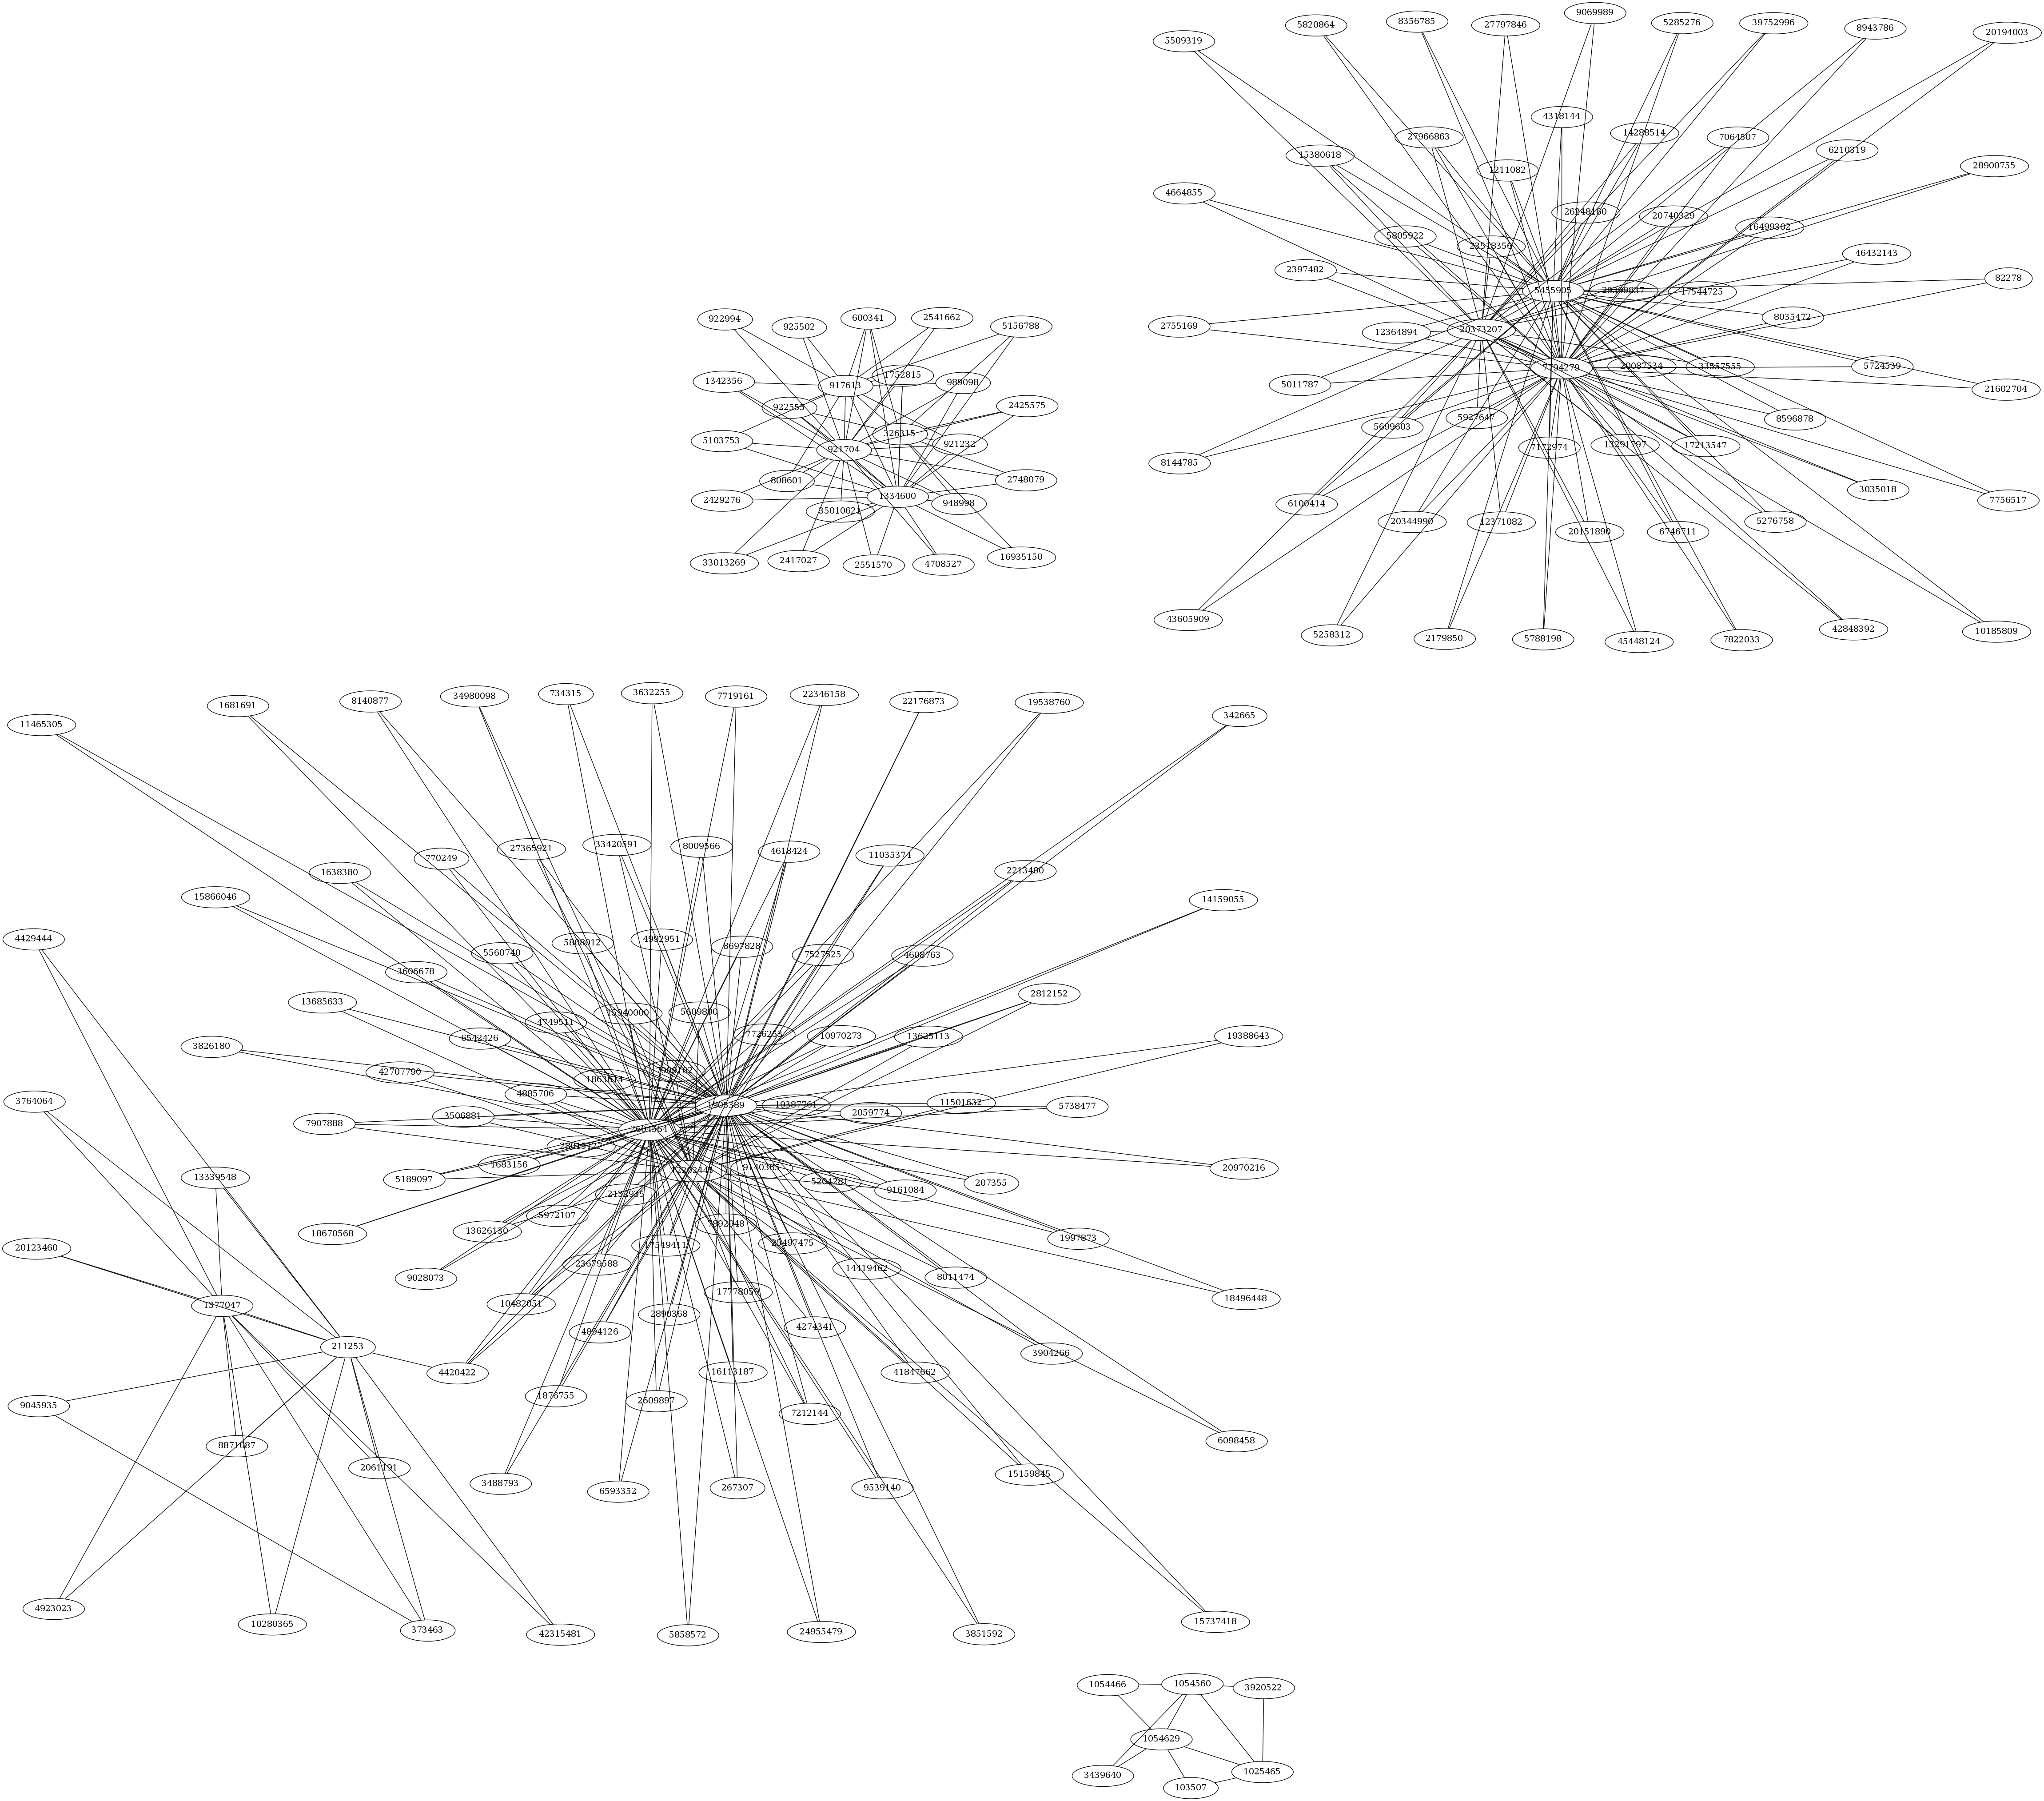

In [120]:
g.graph['overlap'] = False
nxpd.draw(g.subgraph(reduce(lambda a,b: set(a) | set(b), comms)), layout='neato', show='ipynb')

In [180]:
communityNodes = [nodes for nodes in nx.connected_components(g)]
communitySizes = [len(nodes) for nodes in communityNodes]

# make initial list of 'communities of interest'
# defined here as connected components of size > 2 and < 30
commsOfInterest = [(i, communitySizes[i]) for i in range(len(communitySizes))\
               if communitySizes[i] > 2 and communitySizes[i] < 30]

# 'reduce' the subgraphs of interest:
# for each subgraph in commsOfInterest, prune all nodes with local clustering
# coefficient zero, then keep the subgraph if it has any remaining nodes
reducedCommsOfInterest = []
for i, commIndex in enumerate(commsOfInterest):
    sg = g.subgraph(communityNodes[commIndex[0]])
    sgClustering = nx.clustering(sg)
    reducedComm = [node for node in communityNodes[commIndex[0]]\
                  if sgClustering[node] > 0]
    if len(reducedComm) > 0 and nx.number_connected_components(sg.subgraph(reducedComm)) == 1:
        reducedCommsOfInterest.append(reducedComm)

# 'complete' the remaining subgraphs:
# for each subgraph, add all friends of the users in the subgraph, then
# prune the ones with local clustering coefficient zero
completedCommsOfInterest = []
for comm in reducedCommsOfInterest:
    commFriendsLevel1 = {f['userID']: f['friends'] \
                         for f in friendsCollection.find({'userID': {'$in': comm}})\
                        }
    graphCommFriendsLevel1 = nx.from_dict_of_lists(commFriendsLevel1)

    completedCommsOfInterest.append([node for node in graphCommFriendsLevel1.nodes() \
     if nx.clustering(graphCommFriendsLevel1)[node] > 0])

In [179]:
#completedCommsOfInterest

In [137]:
client.database_names()

[u'goodreads_explore_from_book_tnc',
 u'goodreads_explore_multigraph_biased_sampling',
 u'goodreads_explore',
 u'goodreads_full',
 u'goodreads_explore_from_book_hedgehog',
 u'goodreads_explore_from_book_mice_and_men',
 u'local',
 u'goodreads_explore_from_book_jest',
 u'goodreads_explore_from_book_swiftly',
 u'goodreads_explore_from_book',
 u'goodreads_explore_from_book_lies',
 u'goodreads',
 u'goodreads_explore_from_book_divergent',
 u'goodreads_explore_from_book_game_of_thrones',
 u'goodreads_explore_multigraph']

In [229]:
commList = [client['goodreads_explore_from_book_mice_and_men']['comms'].find_one()['comms'],
           client['goodreads_full']['comms'].find_one()['comms']
           ]

In [235]:
print len(commList)
allComms = reduce(lambda a,b: a+b,  [comm for comm in commList])
print len(allComms)
print len(reduce(lambda a,b: a+b, allComms))
print len(reduce(lambda a,b: set(a) | set(b), allComms))

2
30
471
460


In [236]:
found = 0
notFound = 0

for r in client['goodreads_explore_from_book_mice_and_men']['ratings'].find():
    if client['goodreads_full']['ratings'].find({'userID': r['userID']}).count() == 0:
        notFound += 1
    else:
        found += 1
print found, notFound

156 0


In [232]:
lens = []

for b in client['goodreads_full']['books'].find({'commsOfRaters': {'$exists': True}}):
    lens.append(len(b['commsOfRaters']))

In [234]:
client['goodreads_full']['books'].count()

103899

In [231]:
dbFull = client['goodreads_full']
commSets = [set(comm) for comm in allComms]

for j, b in enumerate(dbFull['books'].find()):
    bookID = b['bookID']
    ratingSet = set([int(k) for k in b['ratings'].keys()])
    commsOfRaters = [i for i, comm in enumerate(commSets)\
                    if len(comm & ratingSet) > 0]
    dbFull['books'].update_one(
            {"bookID": bookID},
            {"$set": {'commsOfRaters': commsOfRaters}},
            upsert=True)
    if j % 1000 == 0:
        print float(j) / dbFull['books'].count()

0.0
0.0101788422585
0.020357684517
0.0305365267754
0.0407153690339
0.0508942112924
0.0610730535509
0.0712518958094
0.0814307380679
0.0916095803263
0.101788422585
0.111967264843
0.122146107102
0.13232494936
0.142503791619
0.152682633877
0.162861476136
0.173040318394
0.183219160653
0.193398002911
0.20357684517
0.213755687428
0.223934529687
0.234113371945
0.244292214204
0.254471056462
0.264649898721
0.274828740979
0.285007583237
0.295186425496
0.305365267754
0.315544110013
0.325722952271
0.33590179453
0.346080636788
0.356259479047
0.366438321305
0.376617163564
0.386796005822
0.396974848081
0.407153690339
0.417332532598
0.427511374856
0.437690217115
0.447869059373
0.458047901632
0.46822674389
0.478405586149
0.488584428407
0.498763270666
0.508942112924
0.519120955183
0.529299797441
0.5394786397
0.549657481958
0.559836324216
0.570015166475
0.580194008733
0.590372850992
0.60055169325
0.610730535509
0.620909377767
0.631088220026
0.641267062284
0.651445904543
0.661624746801
0.67180358906
0.6819